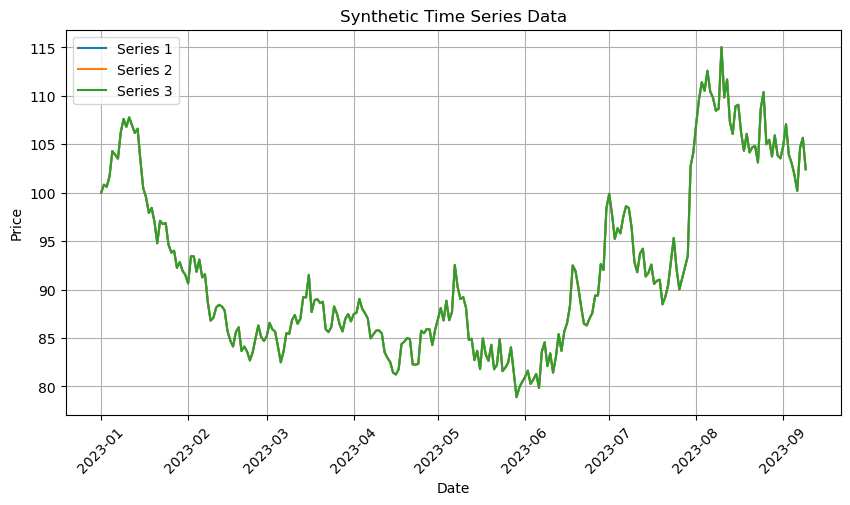

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Folder where the CSV files are stored
DATA_FOLDER = "data/"

# List of CSV files for the first three synthetic series
csv_files = [os.path.join(DATA_FOLDER, f"synthetic_series_{i+1}.csv") for i in range(3)]

# Function to read and plot synthetic time series separately
def plot_synthetic_series_separate(csv_files):
    for i, csv_file in enumerate(csv_files):
        if os.path.exists(csv_file):
            # Read CSV
            df = pd.read_csv(csv_file, parse_dates=["Date"])

            # Create a new figure for each series
            plt.figure(figsize=(10, 5))
            plt.plot(df["Date"], df["Price"], label=f"Series {i+1}", color=f"C{i}")

            # Formatting
            plt.xlabel("Date")
            plt.ylabel("Price")
            plt.title(f"Synthetic Time Series {i+1}")
            plt.legend()
            plt.xticks(rotation=45)
            plt.grid(True)
            plt.show()
        else:
            print(f"⚠️ Warning: {csv_file} not found. Skipping...")

# Plot each series separately
plot_synthetic_series_separate(csv_files)


In [2]:
import torch
import numpy as np
from models.nbeatsx import NBeatsX  # Import your model

# Generate simple synthetic sine wave data
T = 100  # Time steps
input_size = 10  # Lookback window
output_size = 1  # Forecast horizon

# Create a sine wave dataset
time_series = np.sin(np.linspace(0, 10, T)) + np.random.normal(0, 0.1, T)
X = [time_series[i:i+input_size] for i in range(T - input_size)]
Y = [time_series[i+input_size] for i in range(T - input_size)]

# Convert to PyTorch tensors
X, Y = torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32)

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NBeatsX(input_size=input_size, output_size=output_size).to(device)

# Run a forward pass
model.eval()
with torch.no_grad():
    X_test = X[:5].to(device)  # Test on first 5 samples
    predictions = model(X_test)

print("Predictions:", predictions.cpu().numpy())


Predictions: [[0.07345811]
 [0.06038973]
 [0.06525341]
 [0.06351853]
 [0.05053476]]


1️⃣ CTTS Model (CNN + Transformer Time Series)

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from models.ctts import CTTS  # Ensure model path is correct

# Generate synthetic sine wave data
T = 200  # Total time steps
input_channels = 20  # Look-back window size
output_size = 1
time_series = np.sin(np.linspace(0, 20, T)) + np.random.normal(0, 0.1, T)

# Prepare training data
X = np.array([time_series[i:i+input_size] for i in range(T - input_size)])
Y = np.array([time_series[i+input_size] for i in range(T - input_size)])

# Convert to tensors
X, Y = torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32)
print(f"Data Shapes -> X: {X.shape}, Y: {Y.shape}")  # Debugging

# Reshape for models requiring extra dimensions
X = X.unsqueeze(-1)  # Shape: (num_samples, input_size, 1) if needed

# Model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CTTS(input_channels==input_channels).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 50
losses = []
for epoch in range(epochs):
    optimizer.zero_grad()
    preds = model(X.to(device)).squeeze()  # Ensure correct shape
    loss = criterion(preds, Y.to(device))
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    if epoch % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

# Plot training loss
plt.plot(losses, label="Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.title("CTTS Training Loss")
plt.legend()
plt.show()

# Test predictions
model.eval()
with torch.no_grad():
    test_preds = model(X.to(device)).cpu().numpy()

# Plot results
plt.figure(figsize=(10,4))
plt.plot(Y.numpy(), label="Actual", linestyle="dashed")
plt.plot(test_preds, label="Predicted", alpha=0.7)
plt.title("CTTS Predictions on Synthetic Data")
plt.legend()
plt.show()


Data Shapes -> X: torch.Size([180, 20]), Y: torch.Size([180])


/opt/anaconda3/envs/finance/lib/python3.13/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


RuntimeError: Given groups=1, weight of size [64, 1, 3], expected input[180, 20, 1] to have 1 channels, but got 20 channels instead

2️⃣ Temporal Fusion Transformer (TFT)

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from models.tft import TemporalFusionTransformer  # Import TFT model

# Generate synthetic sine wave data
T = 200
input_size = 20
time_series = np.sin(np.linspace(0, 20, T)) + np.random.normal(0, 0.1, T)

X = [time_series[i:i+input_size] for i in range(T - input_size)]
Y = [time_series[i+input_size] for i in range(T - input_size)]
X, Y = torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32)

# Model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TemporalFusionTransformer(input_size=input_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 50
losses = []
for epoch in range(epochs):
    optimizer.zero_grad()
    preds = model(X.to(device))
    loss = criterion(preds.squeeze(), Y.to(device))
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# Plot training loss
plt.plot(losses, label="Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.title("TFT Training Loss")
plt.legend()
plt.show()

# Test predictions
model.eval()
with torch.no_grad():
    test_preds = model(X.to(device)).cpu().numpy()

# Plot results
plt.figure(figsize=(10,4))
plt.plot(Y.numpy(), label="Actual", linestyle="dashed")
plt.plot(test_preds, label="Predicted", alpha=0.7)
plt.title("TFT Predictions on Synthetic Data")
plt.legend()
plt.show()


/opt/anaconda3/envs/finance/lib/python3.13/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


IndexError: too many indices for tensor of dimension 2

3️⃣ DeepAR Model (Autoregressive RNN)

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from models.deepar import DeepAR  # Import DeepAR model

# Generate synthetic sine wave data
T = 200
input_size = 20
time_series = np.sin(np.linspace(0, 20, T)) + np.random.normal(0, 0.1, T)

X = [time_series[i:i+input_size] for i in range(T - input_size)]
Y = [time_series[i+input_size] for i in range(T - input_size)]
X, Y = torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32)

# Model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepAR(input_size=input_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 50
losses = []
for epoch in range(epochs):
    optimizer.zero_grad()
    preds = model(X.to(device))
    loss = criterion(preds.squeeze(), Y.to(device))
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# Plot training loss
plt.plot(losses, label="Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.title("DeepAR Training Loss")
plt.legend()
plt.show()

# Test predictions
model.eval()
with torch.no_grad():
    test_preds = model(X.to(device)).cpu().numpy()

# Plot results
plt.figure(figsize=(10,4))
plt.plot(Y.numpy(), label="Actual", linestyle="dashed")
plt.plot(test_preds, label="Predicted", alpha=0.7)
plt.title("DeepAR Predictions on Synthetic Data")
plt.legend()
plt.show()


IndexError: too many indices for tensor of dimension 2

In [3]:
import os
import sys
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Ensure correct working directory
SCRIPT_DIR = os.getcwd()
PROJECT_ROOT = os.path.abspath(os.path.join(SCRIPT_DIR, ".."))
sys.path.append(PROJECT_ROOT)  # Ensure imports work

# Import models
from models.nbeatsx import NBeatsX
from models.ctts import CTTS
from models.tft import TemporalFusionTransformer
from models.deepar import DeepAR



In [8]:

from utils.preprocessing import prepare_data  # Data preparation function
from training.hyperparameters import HPARAMS  # Load hyperparameters
from data.synthetic_data import generate_multiple_series  # Synthetic data

# Set device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generate synthetic data
synthetic_data = generate_multiple_series(num_series=1, T=252)  # 1 year of data
train_data = synthetic_data["synthetic_series_1"]
X_train, Y_train = prepare_data(train_data)

# Create DataLoader
dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(Y_train, dtype=torch.float32))
train_loader = DataLoader(dataset, batch_size=HPARAMS["batch_size"], shuffle=True)

# Define models
models = {
    "nbeatsx": NBeatsX(input_size=HPARAMS["input_size"], output_size=1).to(DEVICE),
    "ctts": CTTS().to(DEVICE),
    "tft": TemporalFusionTransformer(input_size=HPARAMS["input_size"]).to(DEVICE),
    "deepar": DeepAR(input_size=HPARAMS["input_size"]).to(DEVICE),
}

# Training function
def train_model(model, train_loader, criterion, optimizer, epochs=50):
    model.to(DEVICE)
    model.train()
    losses = []
    for epoch in range(epochs):
        epoch_loss = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")
    return model, losses

# Train all models
save_path = os.path.join(PROJECT_ROOT, "saved_models/")
os.makedirs(save_path, exist_ok=True)

criterion = nn.MSELoss()
all_losses = {}

for name, model in models.items():
    print(f"\nTraining {name.upper()}...")
    optimizer = optim.Adam(model.parameters(), lr=HPARAMS["learning_rate"])
    trained_model, losses = train_model(model, train_loader, criterion, optimizer, HPARAMS["epochs"])
    torch.save(trained_model.state_dict(), os.path.join(save_path, f"{name}.pth"))
    all_losses[name] = losses
    print(f"✅ Model {name} saved.")

# Plot training losses
plt.figure(figsize=(10,5))
for name, losses in all_losses.items():
    plt.plot(losses, label=name)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Losses for Models")
plt.legend()
plt.show()

TypeError: float() argument must be a string or a real number, not 'Timestamp'